In [1]:
import arviz as az
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pymc as pm
import preliz as pz
import xarray as xr
from scipy.interpolate import PchipInterpolator
from scipy.stats import linregress

WARNING (pytensor.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


In [2]:
az.style.use("arviz-grayscale")
from cycler import cycler

default_cycler = cycler(color=["#000000", "#6a6a6a", "#bebebe", "#2a2eec"])
plt.rc("axes", prop_cycle=default_cycler)
plt.rc("figure", dpi=300)
np.random.seed(123)

<Axes: xlabel='temperature', ylabel='rented'>

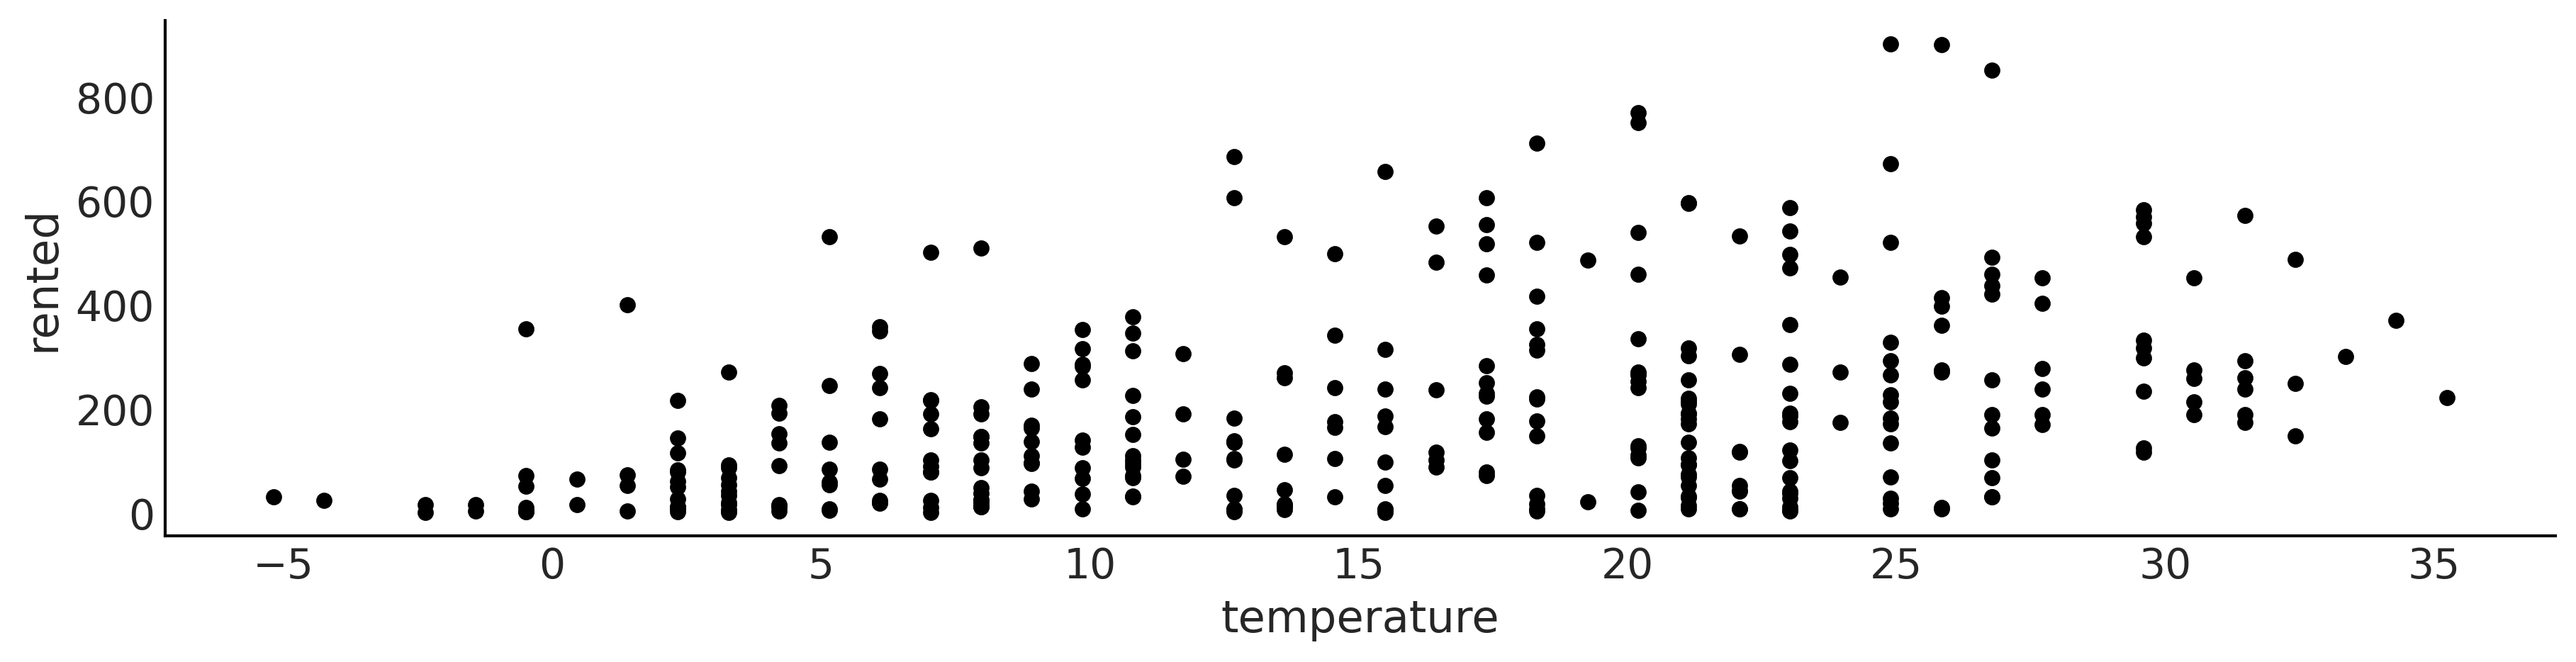

In [3]:
bikes = pd.read_csv("data/bikes.csv")
bikes.plot(x="temperature", y="rented", figsize=(12, 3), kind="scatter")

In [4]:
with pm.Model() as model_lb:
    α = pm.Normal("α", mu=0, sigma=100)
    β = pm.Normal("β", mu=0, sigma=10)
    σ = pm.HalfCauchy("σ", 10)
    μ = pm.Deterministic("μ", α + β * bikes.temperature)
    y_pred = pm.Normal("y_pred", mu=μ, sigma=σ, observed=bikes.rented)
    idata_lb = pm.sample(random_seed=123)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [α, β, σ]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 1 seconds.


array([<Axes: title={'center': 'α'}>, <Axes: title={'center': 'β'}>,
       <Axes: title={'center': 'σ'}>], dtype=object)

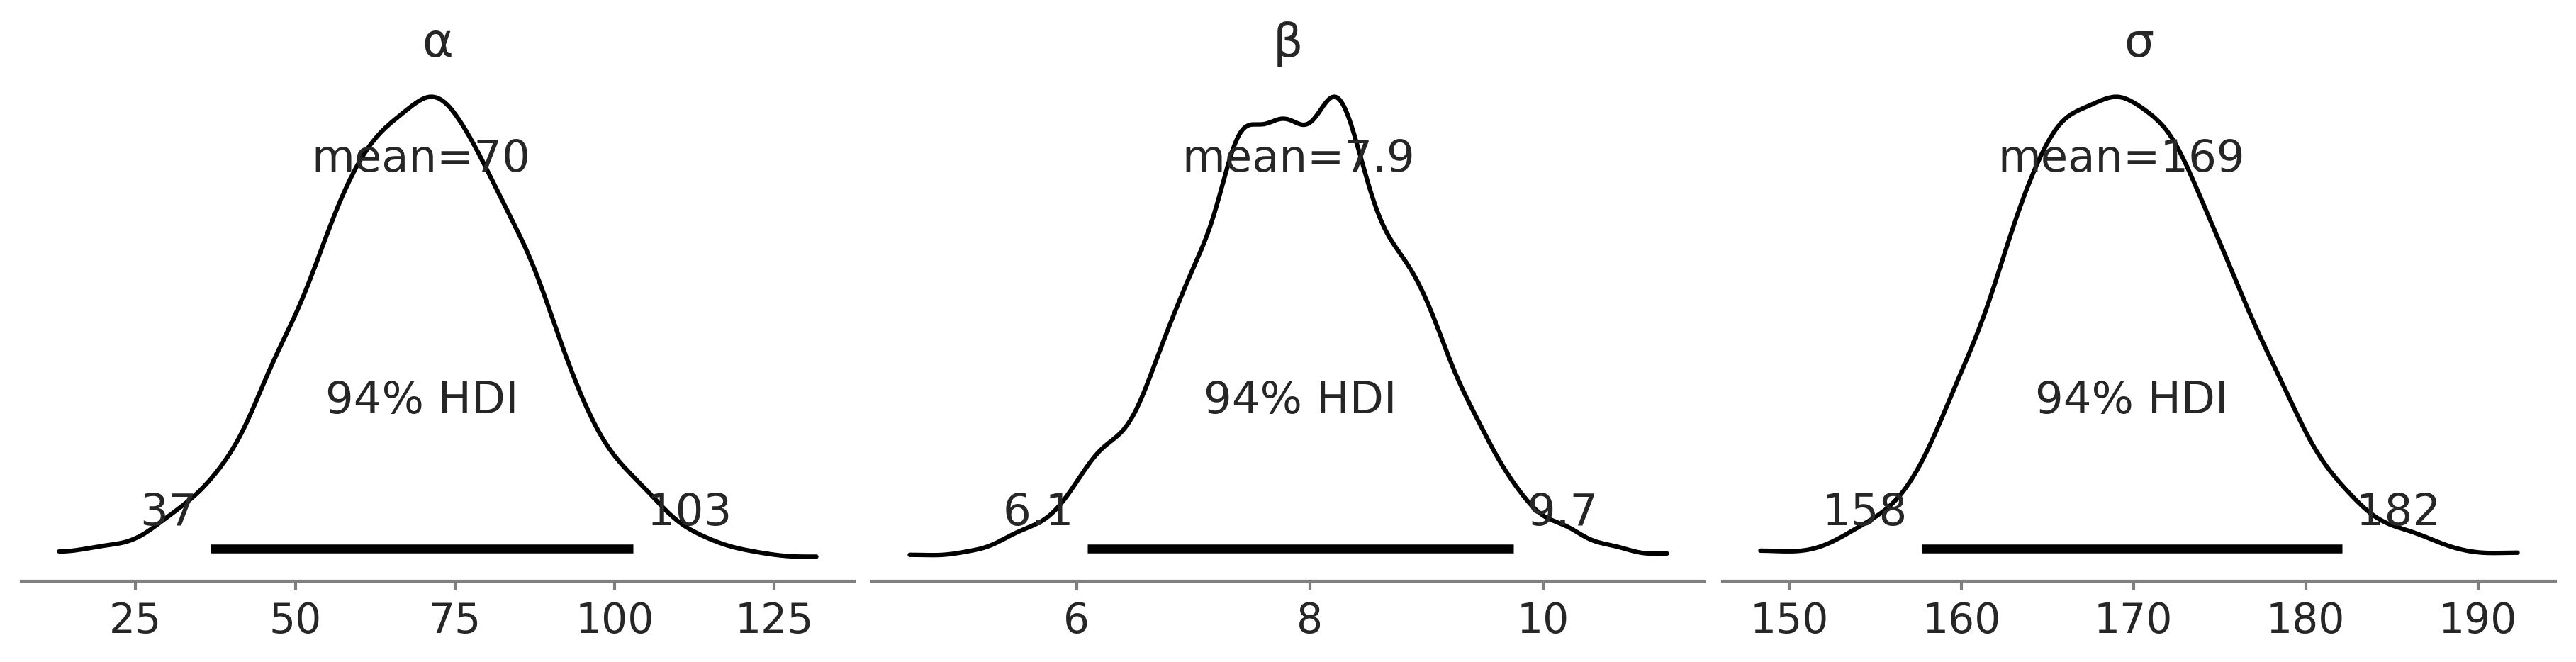

In [5]:
az.plot_posterior(idata_lb, var_names=["~μ"], figsize=(12, 3))

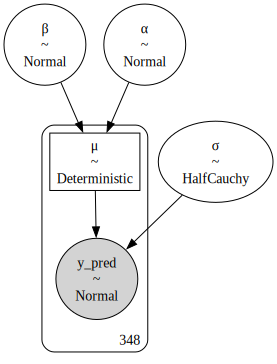

In [6]:
pm.model_to_graphviz(model_lb)

In [7]:
idata_lb

Inference data with groups:
	> posterior
	> sample_stats
	> observed_data

In [48]:
posterior = az.extract(idata_lb, num_samples=50)
# x_plot = np.linspace(bikes.temperature.min(), bikes.temperature.max(), 50).reshape(50,-1)
x_plot = xr.DataArray(
    np.linspace(bikes.temperature.min(), bikes.temperature.max(), 50),
    dims="plot_id"
)

In [49]:
posterior

<xarray.Dataset>
Dimensions:  (sample: 50, μ_dim_0: 348)
Coordinates:
  * μ_dim_0  (μ_dim_0) int64 0 1 2 3 4 5 6 7 ... 340 341 342 343 344 345 346 347
  * sample   (sample) object MultiIndex
  * chain    (sample) int64 0 2 3 1 0 3 0 2 3 0 0 0 ... 0 0 3 0 2 0 3 1 2 1 0 3
  * draw     (sample) int64 410 848 592 820 128 295 ... 688 354 364 463 318 649
Data variables:
    α        (sample) float64 103.4 87.7 80.76 64.66 ... 67.58 79.43 75.97 76.61
    β        (sample) float64 6.612 6.982 7.986 8.007 ... 8.063 8.622 7.316
    σ        (sample) float64 164.5 173.0 180.2 169.8 ... 170.9 165.1 182.2
    μ        (μ_dim_0, sample) float64 125.1 110.6 107.0 ... 143.8 144.8 135.0
Attributes:
    created_at:                 2024-04-06T23:51:43.687474
    arviz_version:              0.17.0
    inference_library:          pymc
    inference_library_version:  5.8.0
    sampling_time:              1.1907939910888672
    tuning_steps:               1000

In [50]:
x_plot.shape

(50,)

In [51]:
mean_line = posterior["α"].mean() + posterior["β"].mean() * x_plot

In [52]:
mean_line.shape

(50,)

In [13]:
lines = posterior["α"] + posterior["β"] * x_plot
hdi_lines = az.hdi(idata_lb.posterior["μ"])

In [14]:
hdi_lines

<xarray.Dataset>
Dimensions:  (μ_dim_0: 348, hdi: 2)
Coordinates:
  * μ_dim_0  (μ_dim_0) int64 0 1 2 3 4 5 6 7 ... 340 341 342 343 344 345 346 347
  * hdi      (hdi) <U6 'lower' 'higher'
Data variables:
    μ        (μ_dim_0, hdi) float64 69.11 125.2 31.81 ... 125.2 109.8 153.7

In [15]:
lines.T

<xarray.DataArray (plot_id: 50, sample: 50)>
array([[ 61.43415185,   4.21248694,  -3.19904372, ...,  48.37069425,
          1.92352063,  39.5549495 ],
       [ 67.05580741,  11.86735735,   4.57749504, ...,  54.42771247,
          9.28941019,  45.37092873],
       [ 72.67746297,  19.52222775,  12.35403379, ...,  60.48473069,
         16.65529975,  51.18690796],
       ...,
       [325.6519632 , 363.99139588, 362.29827768, ..., 333.05055079,
        348.12032988, 312.9059733 ],
       [331.27361876, 371.64626628, 370.07481643, ..., 339.10756901,
        355.48621944, 318.72195253],
       [336.89527433, 379.30113668, 377.85135519, ..., 345.16458724,
        362.852109  , 324.53793176]])
Coordinates:
  * sample   (sample) object MultiIndex
  * chain    (sample) int64 2 0 1 0 1 1 0 0 0 3 2 0 ... 2 1 2 0 1 2 0 1 1 0 2 0
  * draw     (sample) int64 846 99 954 299 61 307 903 ... 897 935 48 6 132 328
Dimensions without coordinates: plot_id

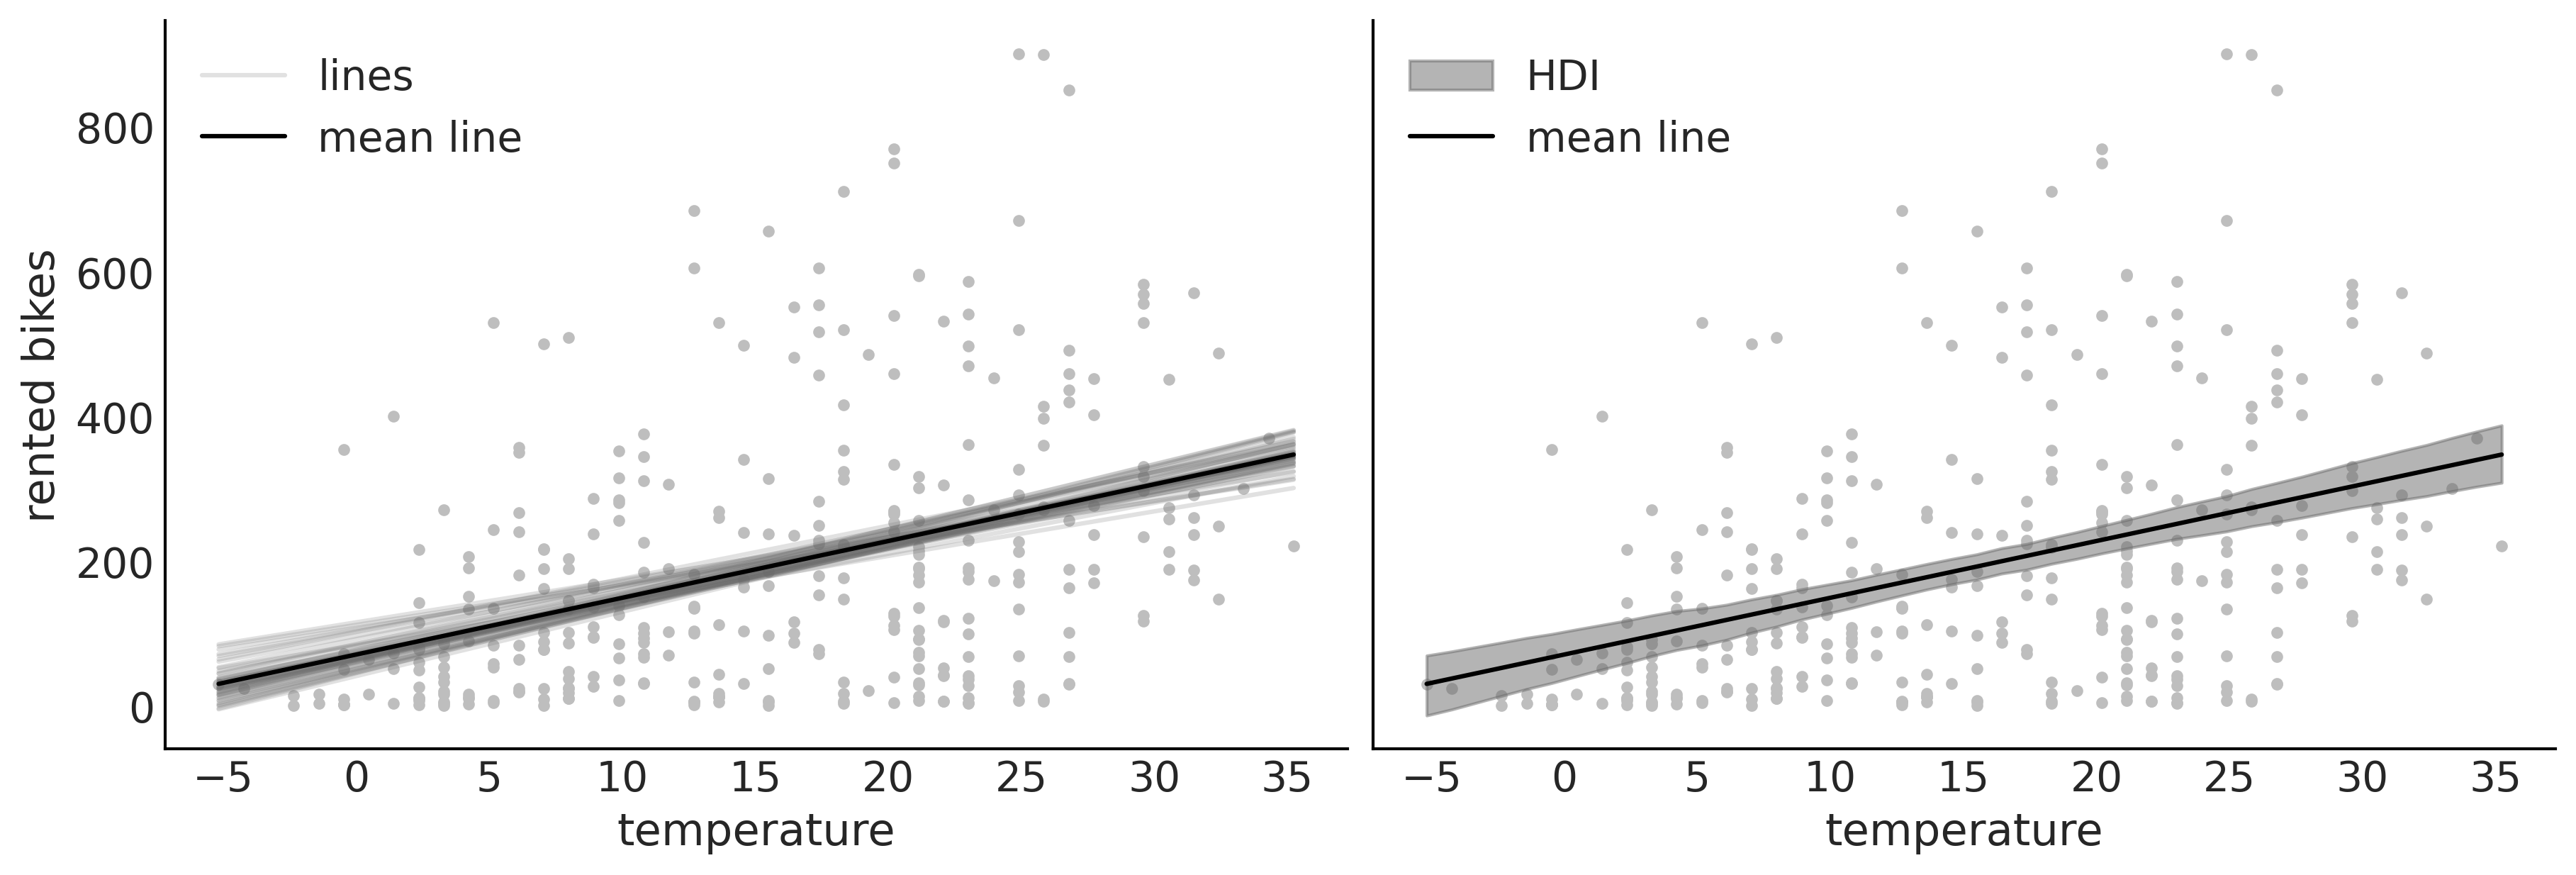

In [16]:
fig, axes = plt.subplots(1, 2, figsize=(12, 4), sharey=True)
axes[0].plot(bikes.temperature, bikes.rented, "C2.", zorder=-3)
lines_ = axes[0].plot(x_plot, lines.T, c="C1", alpha=0.2, label="lines")
plt.setp(lines_[1:], label="_")
axes[0].plot(x_plot, mean_line, c="C0", label="mean line")
axes[0].set_xlabel("temperature")
axes[0].set_ylabel("rented bikes")
axes[0].legend()

axes[1].plot(bikes.temperature, bikes.rented, "C2.", zorder=-3)
idx = np.argsort(bikes.temperature.values)
axes[1].fill_between(
    bikes.temperature[idx],
    hdi_lines["μ"][:,0][idx],
    hdi_lines["μ"][:,1][idx],
    color="C1",
    label="HDI",
    alpha=0.5,
) 
axes[1].plot(x_plot, mean_line, c="C0", label="mean line")
axes[1].set_xlabel("temperature")
axes[1].legend()

In [ ]:
hdi_lines["μ"][:,0]

In [53]:
pm.sample_posterior_predictive(idata_lb, model=model_lb, extend_inferencedata=True)

Sampling: [y_pred]


Inference data with groups:
	> posterior
	> posterior_predictive
	> sample_stats
	> observed_data

In [119]:
mean_line = idata_lb.posterior["μ"].mean(("chain", "draw"))

In [120]:
temperatures = np.random.normal(bikes.temperature.values, 0.01)

In [121]:
idx=np.argsort(temperatures)

In [122]:
x = np.linspace(temperatures.min(), temperatures.max(), 15)

In [123]:
y_pred_q = idata_lb.posterior_predictive["y_pred"].quantile(
    [0.03, 0.97, 0.25, 0.75], dim=["chain", "draw"]
)

In [124]:
y_hat_bounds = iter(
    [
        PchipInterpolator(temperatures[idx], y_pred_q[i][idx])(x)
        for i in range(4)
    ]
)

Text(0, 0.5, 'rented bikes')

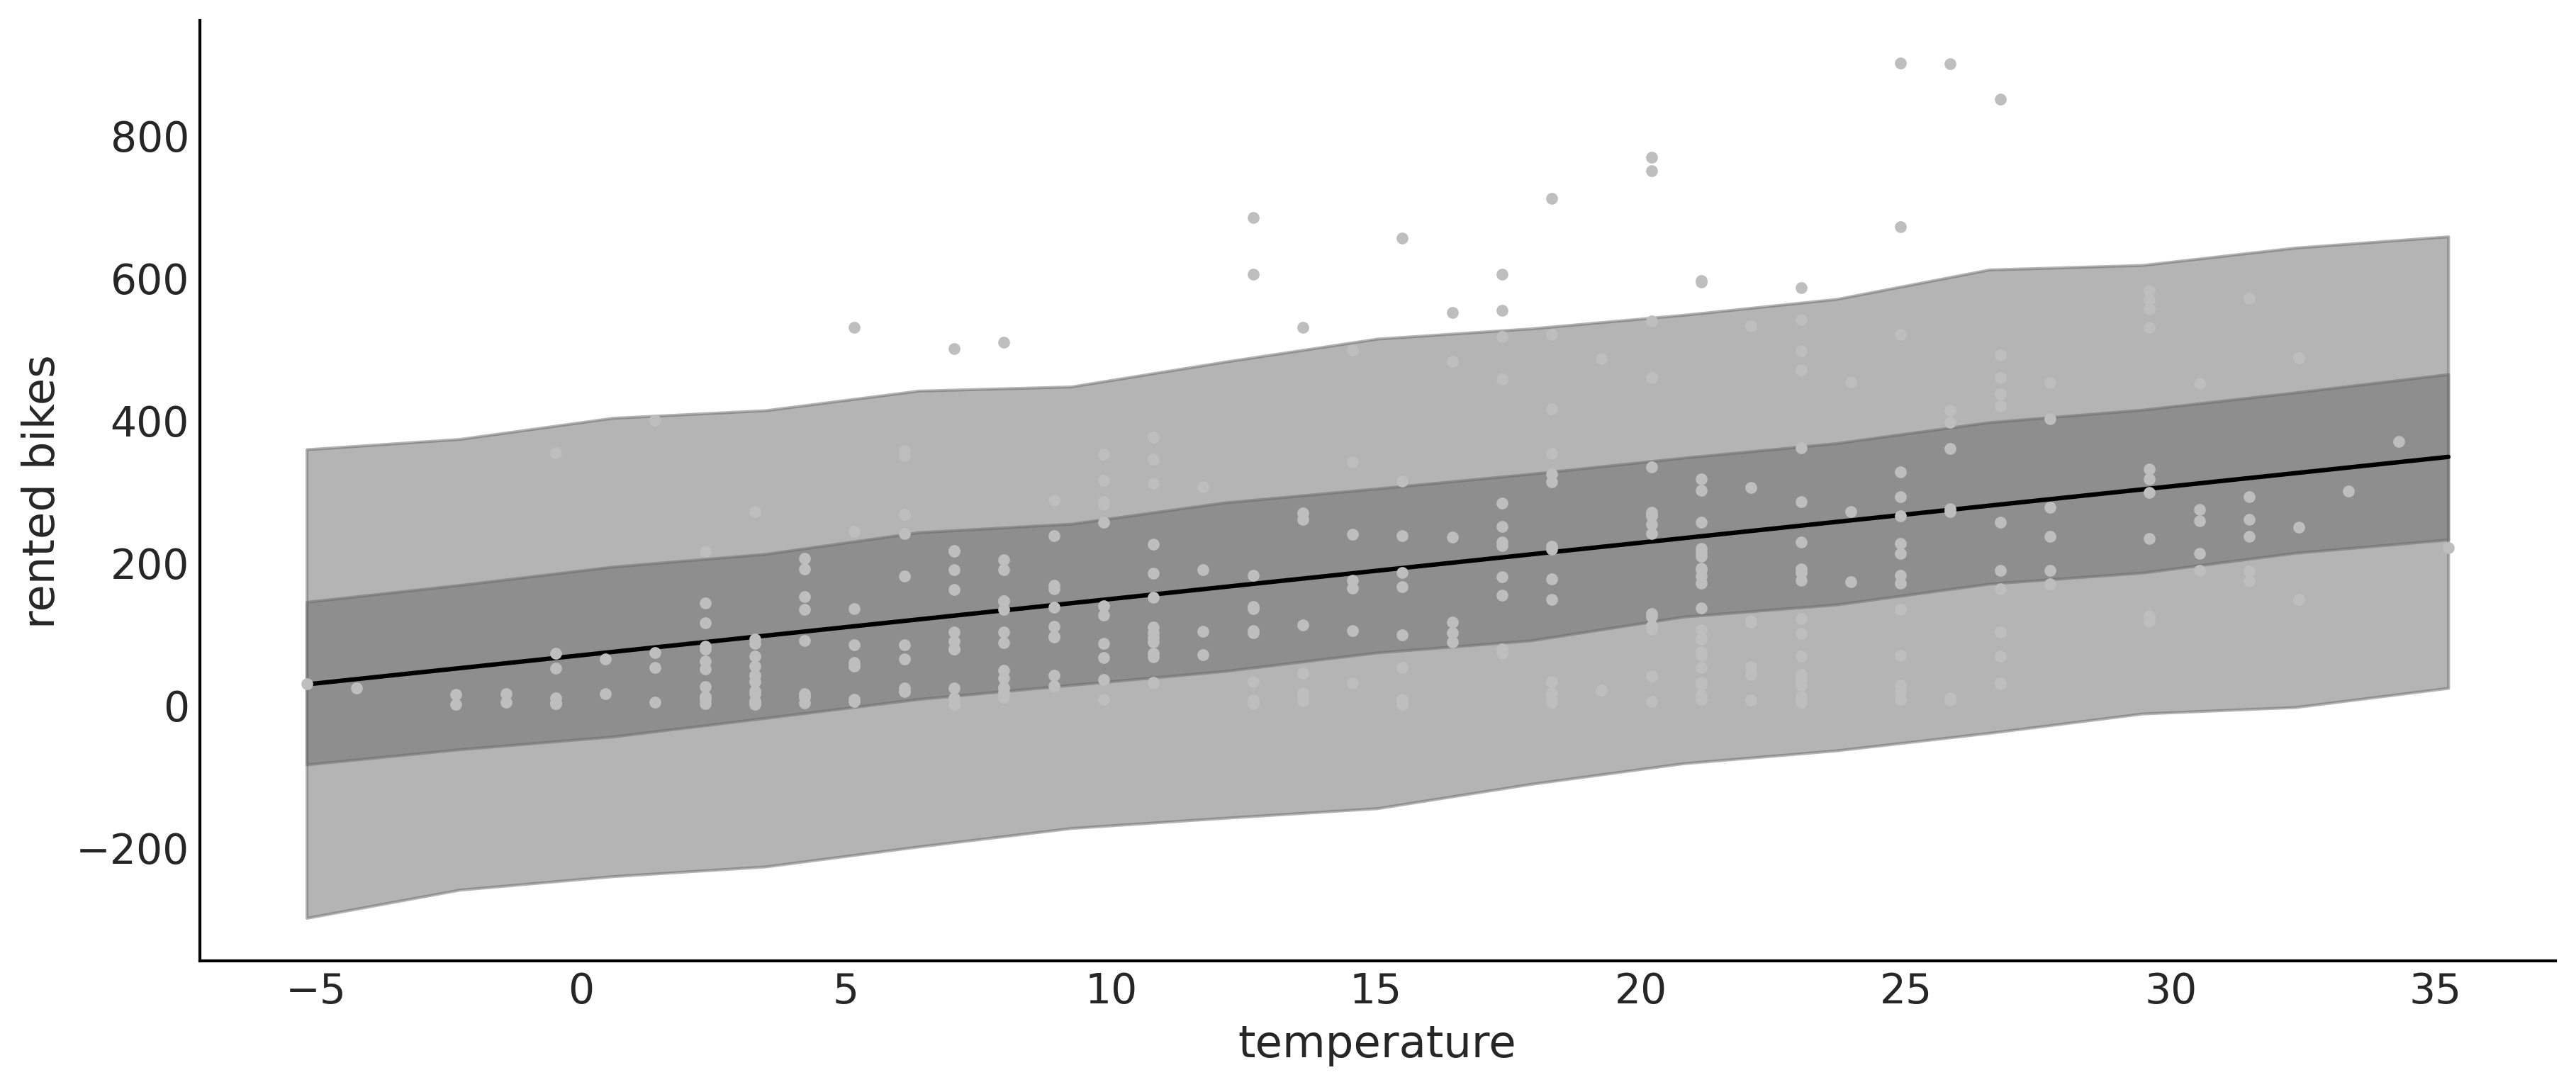

In [125]:
_, ax = plt.subplots(figsize=(12,5))
ax.plot(bikes.temperature, bikes.rented, "C2.", zorder=3)
ax.plot(bikes.temperature[idx], mean_line[idx], c="C0")

for lb, ub in zip(y_hat_bounds, y_hat_bounds):
    ax.fill_between(x, lb, ub, color="C1", alpha=0.5)

ax.set_xlabel("temperature")
ax.set_ylabel("rented bikes")

## 4.4 Counting bikes

In [128]:
with pm.Model() as model_neg:
    α = pm.Normal("α", mu=0, sigma=1)
    β = pm.Normal("β", mu=0, sigma=10)
    σ = pm.HalfNormal("σ", 10)
    μ = pm.Deterministic("μ", pm.math.exp(α + β * bikes.temperature))
    y_pred = pm.NegativeBinomial("y_pred", mu=μ, alpha=σ, observed=bikes.rented)
    idata_neg = pm.sample()
    idata_neg.extend(pm.sample_posterior_predictive(idata_neg))

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [α, β, σ]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 2 seconds.
Sampling: [y_pred]


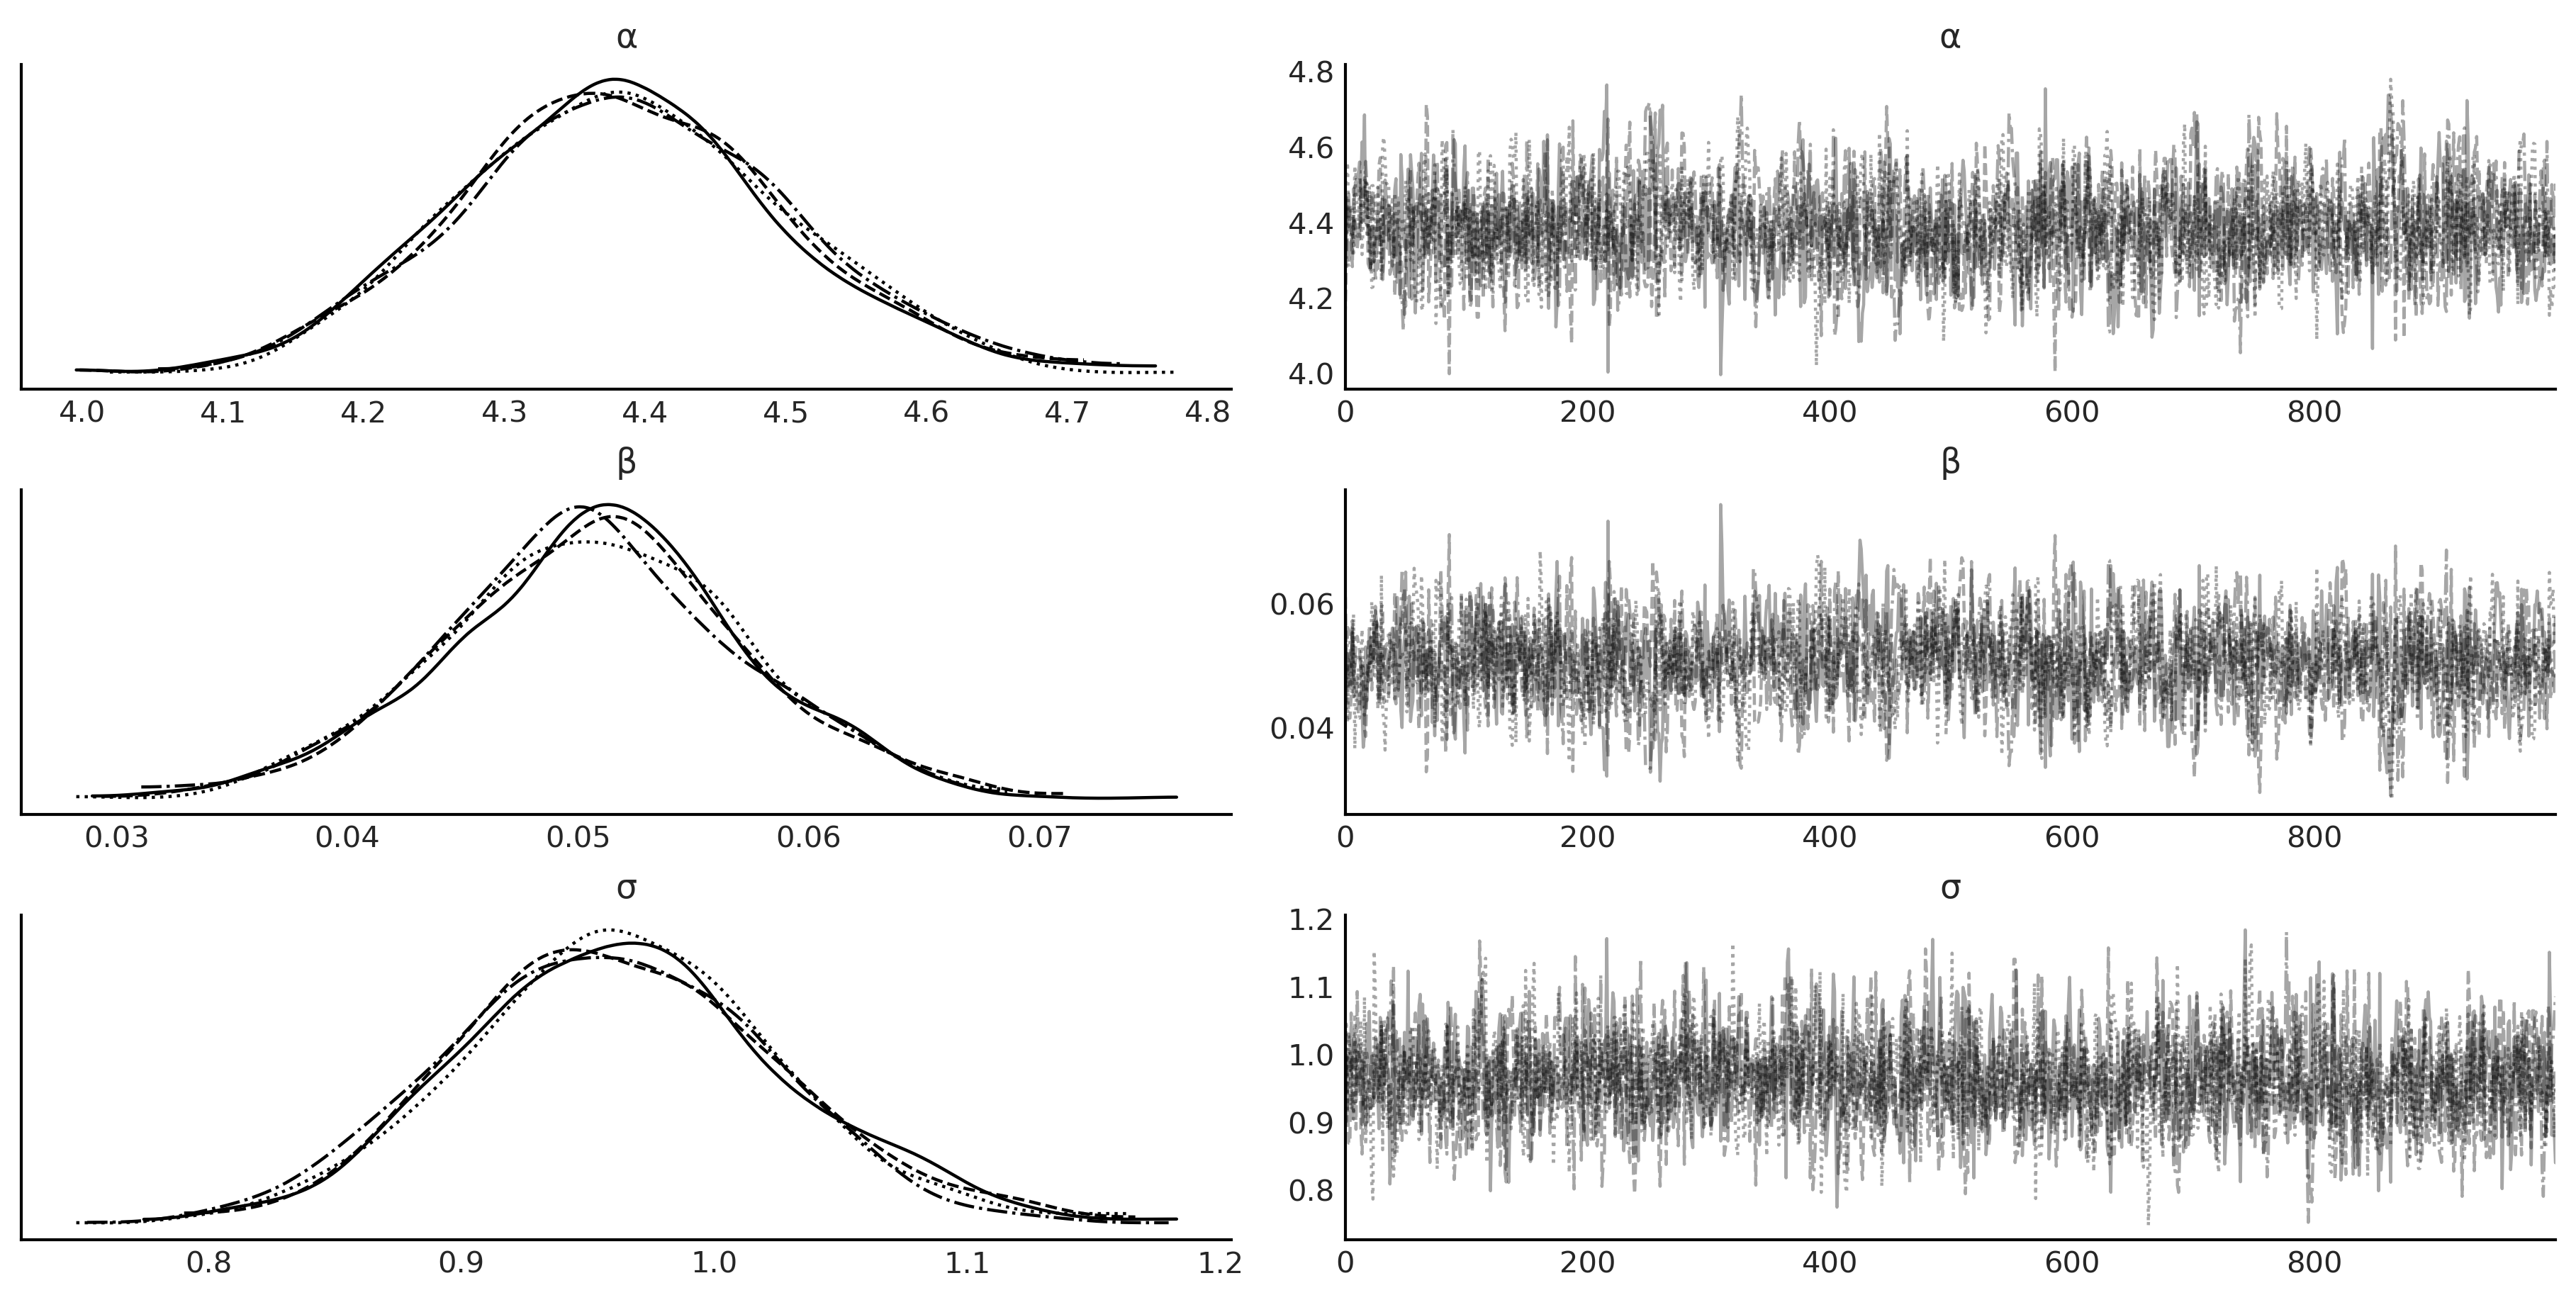

In [129]:
az.plot_trace(idata_neg, var_names=["~μ"]);

Text(0, 0.5, 'rented bikes')

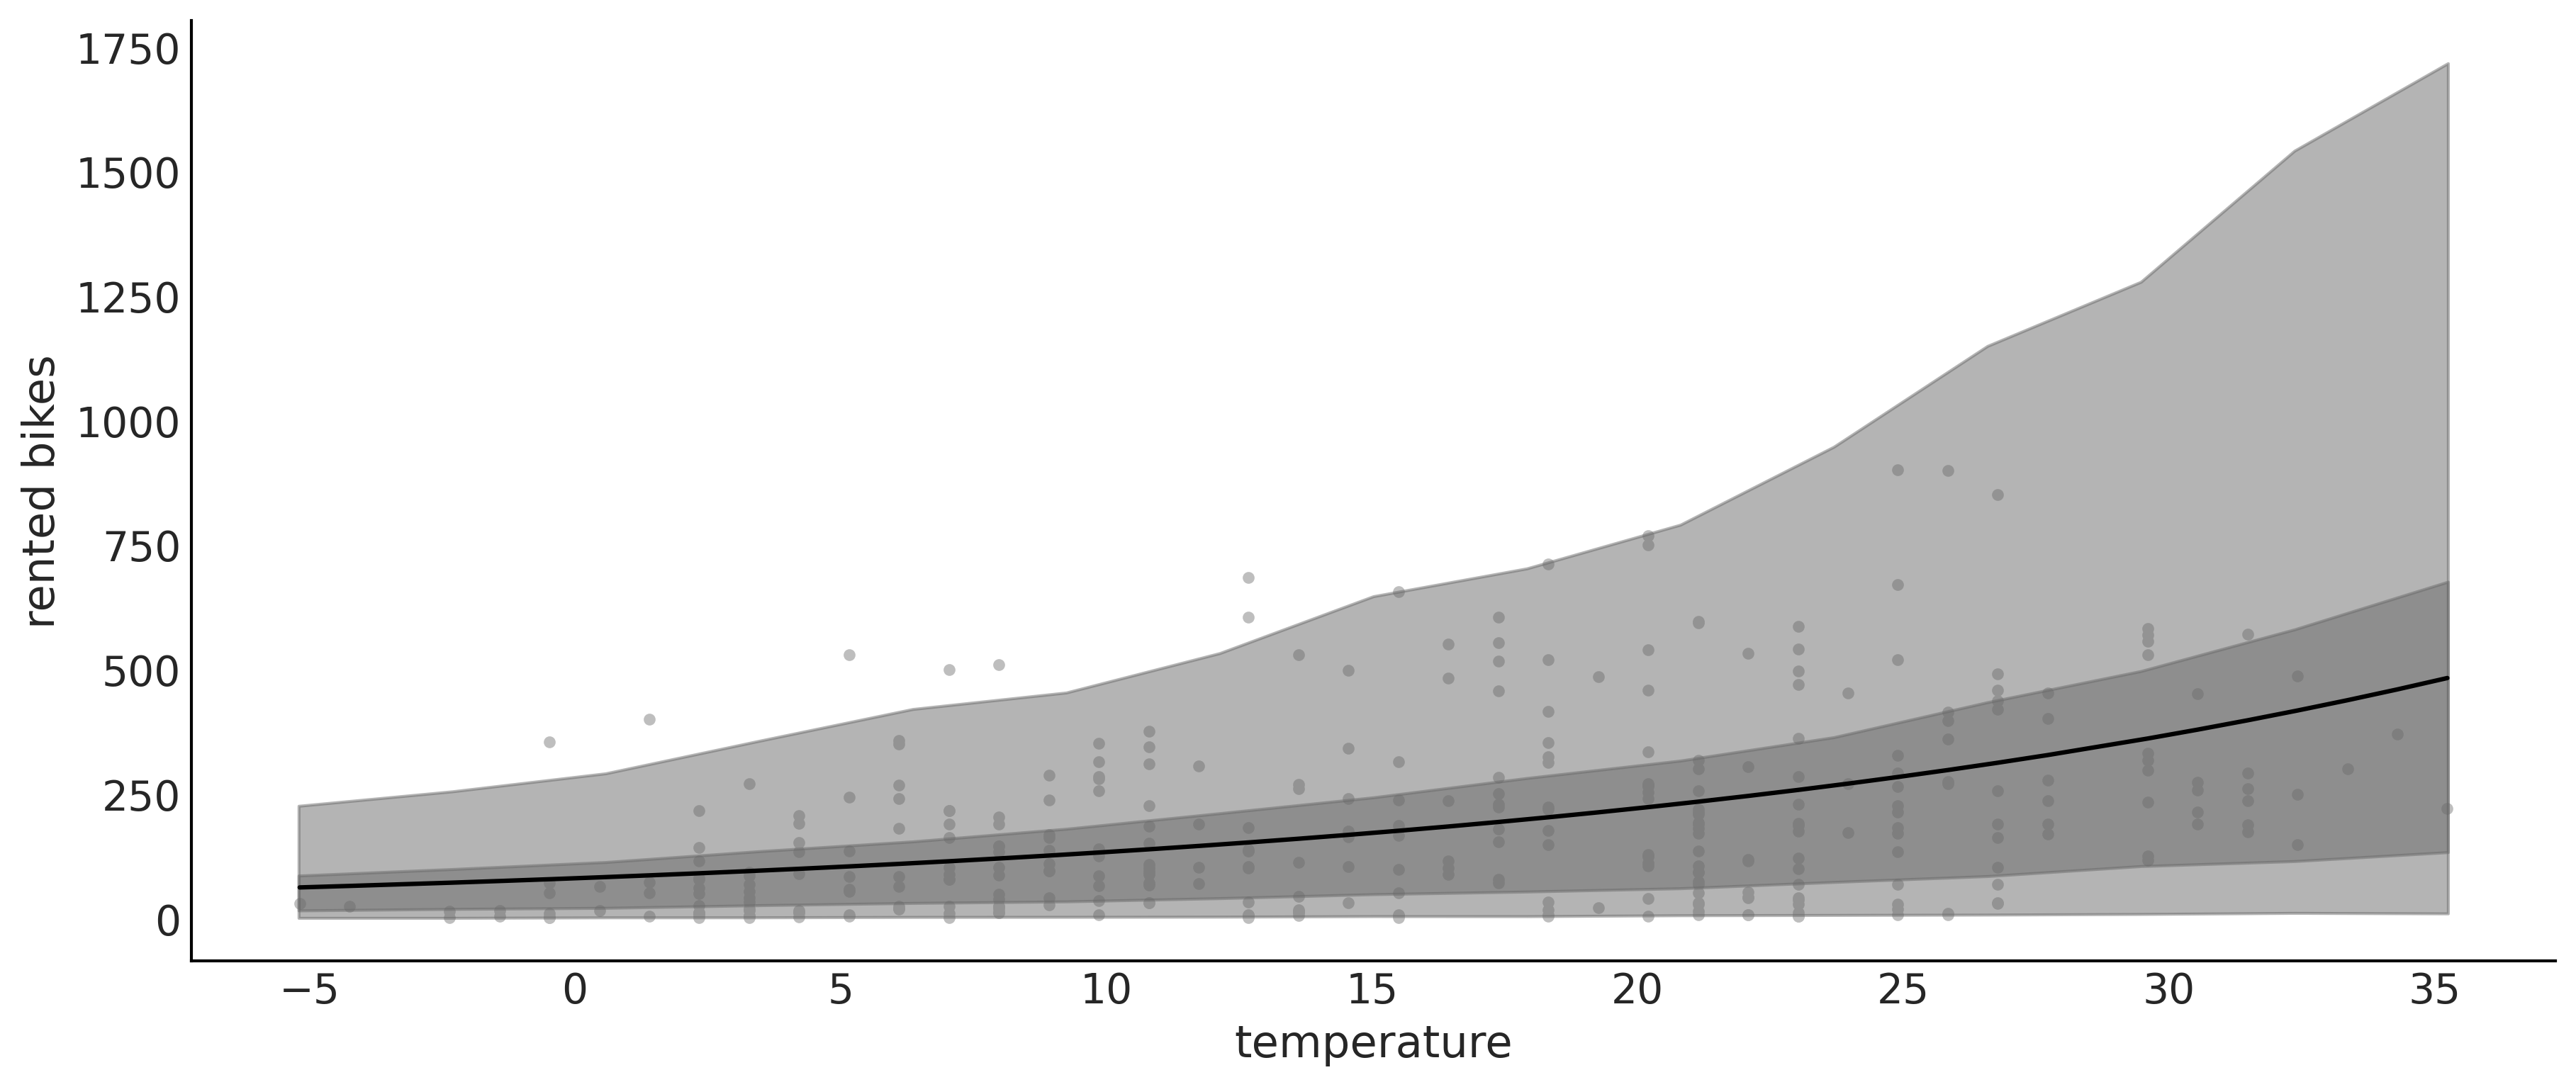

In [130]:
mean_line = idata_neg.posterior["μ"].mean(("chain", "draw"))
temperatures = np.random.normal(bikes.temperature.values, 0.01)
idx = np.argsort(temperatures)
x = np.linspace(temperatures.min(), temperatures.max(), 15)
y_pred_q = idata_neg.posterior_predictive["y_pred"].quantile(
    [0.03, 0.97, 0.25, 0.75], dim=["chain", "draw"]
)
y_hat_bounds = iter(
    [
        PchipInterpolator(temperatures[idx], y_pred_q[i][idx])(x)
        for i in range(4)
    ]
)

_, ax = plt.subplots(figsize=(12, 5))
ax.plot(bikes.temperature, bikes.rented, "C2.", zorder=-3)
ax.plot(bikes.temperature[idx], mean_line[idx], c="C0")

for lb, ub in zip(y_hat_bounds, y_hat_bounds):
    ax.fill_between(x, lb, ub, color="C1", alpha=0.5)

ax.set_xlabel("temperature")
ax.set_ylabel("rented bikes")

Text(0.5, 1.0, 'NegativeBinomial')

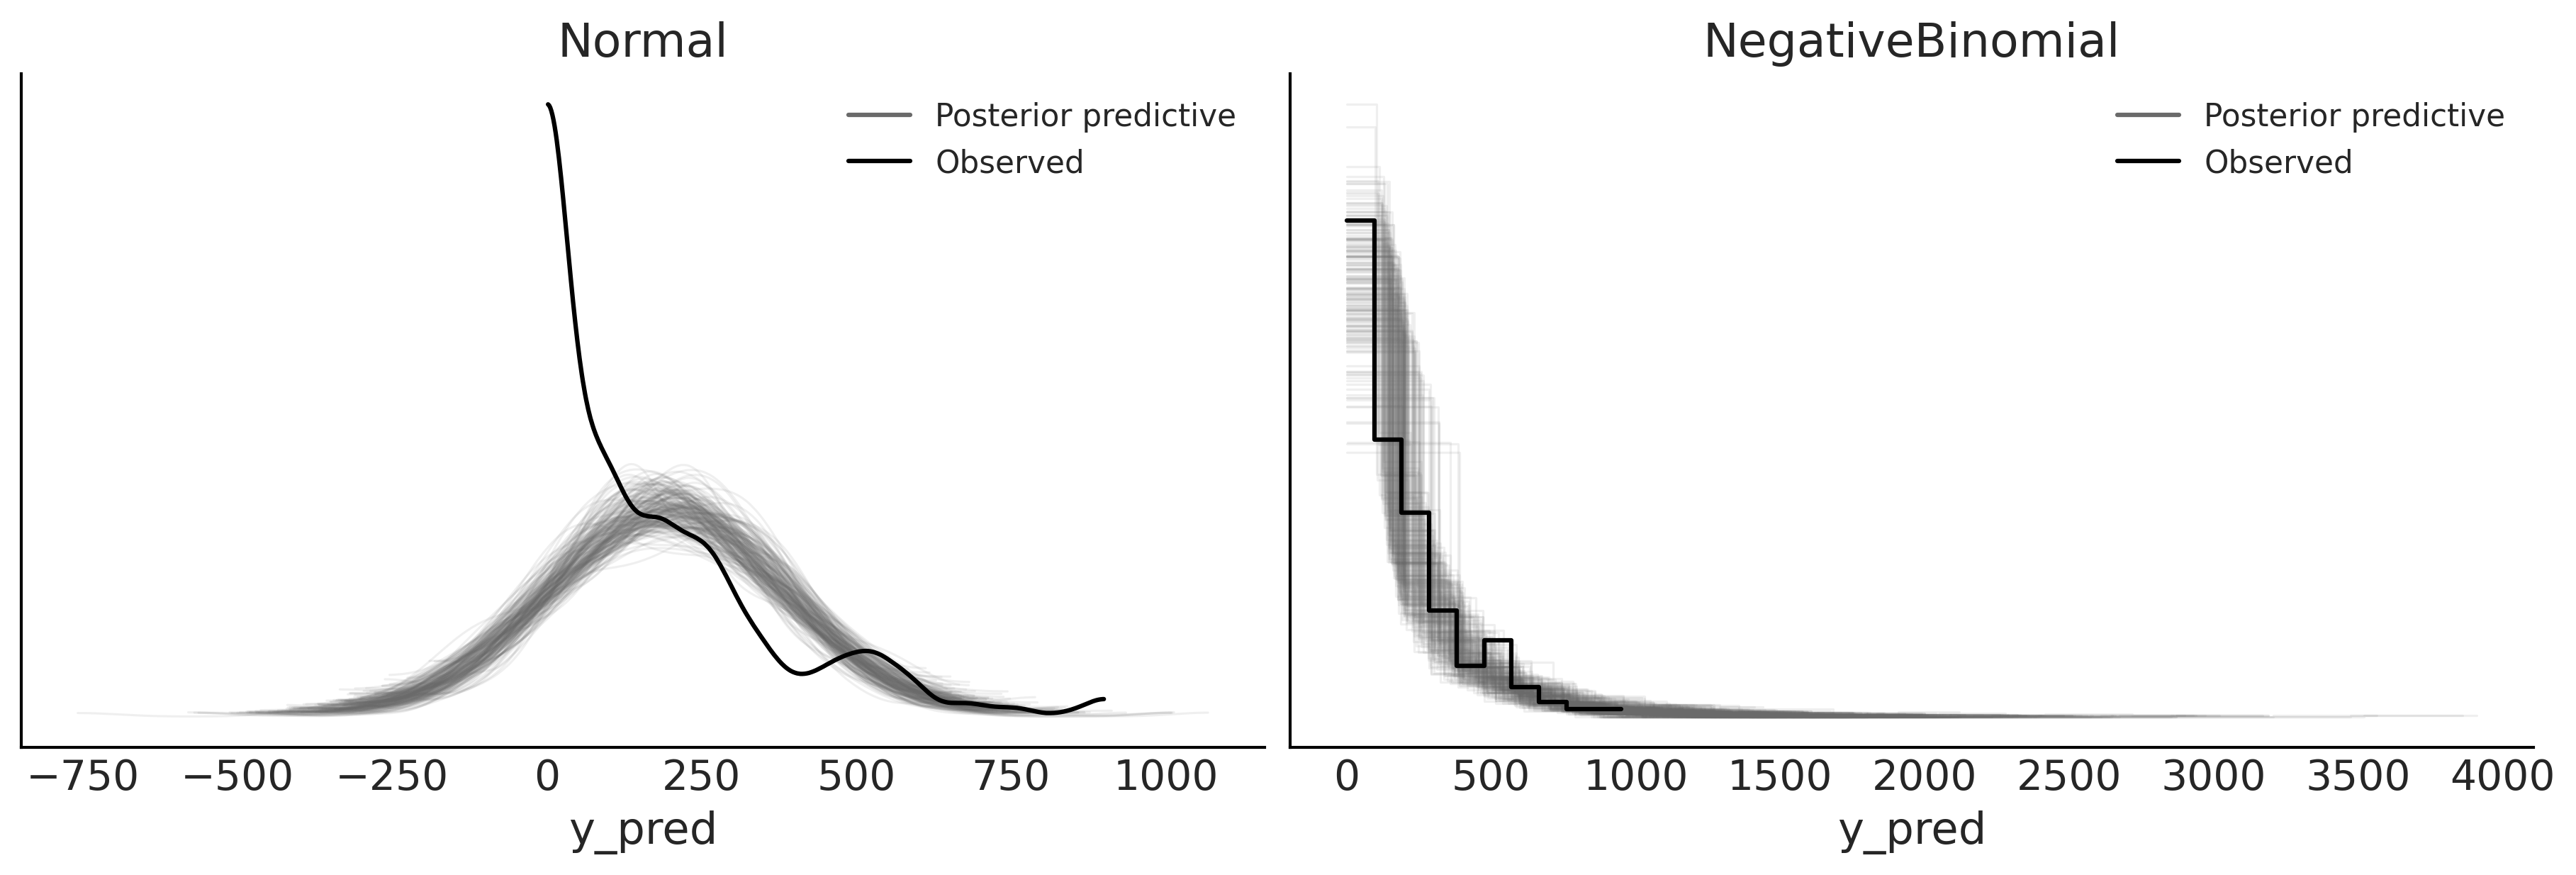

In [135]:
_, ax = plt.subplots(1, 2, figsize=(12, 4))
az.plot_ppc(
    idata_lb,
    num_pp_samples=200,
    alpha=0.1,
    colors=["C1", "C0", "C0"],
    ax=ax[0],
    mean=False,
)
az.plot_ppc(
    idata_neg,
    num_pp_samples=200,
    alpha=0.1,
    colors=["C1", "C0", "C0"],
    ax=ax[1],
    mean=False,
)
ax[0].set_title("Normal")
ax[1].set_title("NegativeBinomial")

## 4.5 Robust regression